In [69]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


# Producing a PCA 
This code will take an input of a featurematrix with an Id column and intensities for each sample with the names PX_tXh

In [70]:
software = input("What software is being used:")

In [71]:
date = input("Enter the date (For naming)")

In [72]:
# Importing the data - MZmine
# df = pd.read_csv(r"C:\Users\adamg\OneDrive - The University of Liverpool\Project Work\MZmine\MZmine_Feature_Matrix.csv")
# Importing the data - XCMS
df = pd.read_csv(r"C:\Users\adamg\OneDrive - The University of Liverpool\Project Work\XCMS\XCMS_Feature_Matrix.csv")


df.head

<bound method NDFrame.head of    Unnamed: 0        P1_t0h       P1_t10h       P1_t11h        P1_t1h  \
0        FT01  3.653040e+05  4.184094e+05  4.276560e+05  3.611035e+05   
1        FT02  4.447987e+05  6.369508e+05  4.249843e+05  3.641180e+05   
2        FT03  6.596271e+05  1.392095e+06  1.417412e+06  6.630007e+05   
3        FT04  2.602568e+05           NaN           NaN           NaN   
4        FT05  3.287398e+05           NaN           NaN  3.480406e+05   
5        FT06  2.380095e+05           NaN           NaN           NaN   
6        FT07  2.903287e+05  2.613087e+05  2.710922e+05  2.550073e+05   
7        FT08  3.032018e+05  4.396733e+05  3.626990e+05           NaN   
8        FT09  5.063149e+06  5.287652e+06  6.120736e+06  4.363780e+06   
9        FT10  1.637029e+06  1.473937e+06  2.236082e+06  1.317978e+06   
10       FT11           NaN           NaN           NaN  4.677500e+05   
11       FT12  1.817352e+06  1.827494e+06  2.702201e+06  2.254661e+06   
12       FT13  8.3008

# Data cleaning
The data needs to be cleaned first. This means removing features that are only present in <10% of the samples, filling in missing values through k-nearest neighbour machine learning and scaling the data 

## Removing rows with low amounts of data

In [73]:
# Before cleaning
df.shape

(36, 119)

In [74]:
threshold = 0.1

# Finds the number of columns with data in 
data_cols = df.notna().sum(axis=1)

df = df[data_cols >= df.shape[1]*threshold]

In [75]:
# After filtering
df.shape

(36, 119)

## Getting Patient Names

In [76]:
x = df.iloc[:,1:].T

# Extracting Patient Names
patients = [name.split('_')[0] for name in x.index]
for i, patient in enumerate(patients):
    patients[i] = patient.replace("P", "Patient ")

# Patient Numbers
unique_patients = np.unique(patients)

# Sorting patients (deals with patient 10)
def sort_patients(patients):
  # Define a function to extract numbers and handle non-numeric parts
  def get_patient_number(patient):
    match = re.search(r'\d+', patient)  # Search for digits
    return int(match.group()) if match else float('inf')  # Extract or assign infinity

  # Sort the patients based on extracted numbers (or infinity for non-numeric)
  return patients[sorted(range(len(patients)), key=lambda i: get_patient_number(patients[i]))]

# Sort the patients
sorted_patients = sort_patients(unique_patients)
sorted_patients



array(['Patient 1', 'Patient 2', 'Patient 3', 'Patient 4', 'Patient 5',
       'Patient 6', 'Patient 7', 'Patient 8', 'Patient 9', 'Patient 10'],
      dtype='<U10')

# Scaling the data

In [77]:
x = StandardScaler().fit_transform(x)

## Filling in missing values 
Using k-nearest neighbour

In [78]:
# Can adjust the number of neighbours
num_neighbours = 2

imputer = KNNImputer(n_neighbors=num_neighbours, weights="uniform")

x = imputer.fit_transform(x)
x

array([[-0.88771674, -0.59906799, -2.10439368, ..., -1.20634742,
        -1.02743047, -0.05549583],
       [ 0.87751615,  0.36177435,  1.70510627, ..., -1.43975508,
        -1.15162638, -0.60249909],
       [ 1.18487253, -0.69814842,  1.83677653, ..., -0.60296909,
        -0.62064234,  0.74624419],
       ...,
       [ 0.67232727,  1.12784782,  1.00920425, ...,  0.82697272,
         0.3429803 ,  0.83932682],
       [ 0.71460622,  1.63678583, -0.67162679, ...,  0.94718179,
         1.54806667,  0.37601467],
       [ 0.79124841,  2.08975258,  1.30291058, ...,  1.4255401 ,
         1.05463467,  1.22734465]])

# Performing PCA analysis

In [79]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=["Principal Component 1","Principal Component 2"])
principalDf["Patient"] = patients

principalDf

,Principal Component 1,Principal Component 2,Patient
0,-4.825826,2.085204,Patient 1
1,-1.902928,0.454636,Patient 1
2,-0.774398,2.790351,Patient 1
3,-5.878463,1.912481,Patient 1
4,-3.615134,3.585499,Patient 1
...,...,...,...
113,6.545360,2.315828,Patient 9
114,7.137518,-0.336050,Patient 9
115,7.147902,1.075557,Patient 9
116,6.487428,1.384470,Patient 9


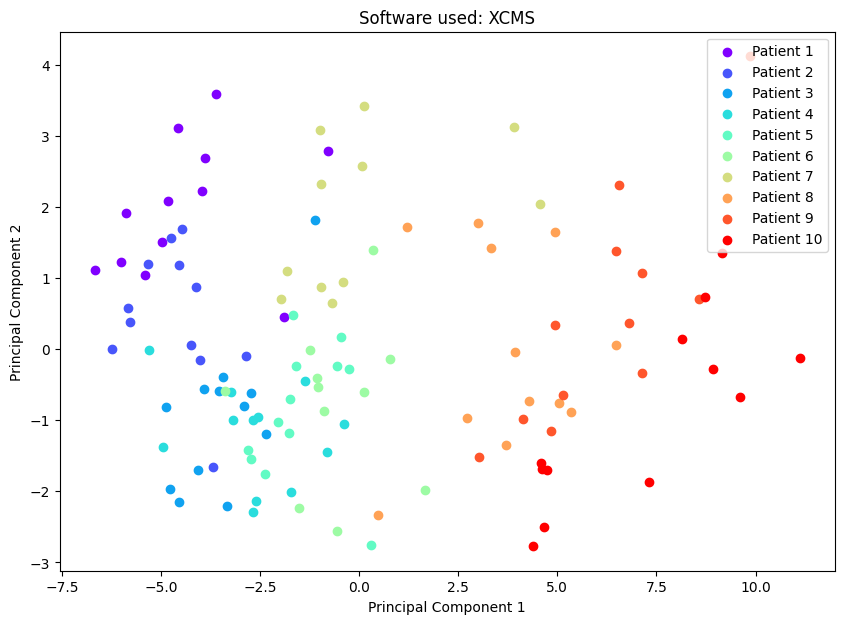

In [80]:
# Asigns each patient a colour
plt.figure(figsize=(10, 7))


colours = plt.cm.rainbow(np.linspace(0, 1, len(sorted_patients)))

# Plots each patients PCA results
for patient, colour in zip(sorted_patients, colours):
    indices = principalDf['Patient'] == patient
    plt.scatter(principalDf.loc[indices, 'Principal Component 1'], principalDf.loc[indices, 'Principal Component 2'], label=patient, color=colour)


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Software used: {software}')
plt.legend()

plt.savefig(f"{software}_{date}_PCA.png", format = "png")
plt.show()
